% Solves the following N,P,Z equations following Franks et al
% (1986).
%
%  dP/dt=Vm*N*P/(Ks+N)-m*P-Z*Rm*(1-exp(-lambda*P))
%  dZ/dt=(1-gamma)*Z*Rm*(1-exp(-lambda*P))-g*Z
%  dN/dt=-Vm*N*P/(Ks+N)+m*P+g*Z+gamma*Z*Rm*(1-exp(-lambda*P))
%
% Uses the code given in Miller (2004), Biological Oceanography, p76.
%
%  Choose zooplankton grazing formulation:
%    igraze=1: Ivlev function
%    igraze=2: Mayzaud-Poulet
%    igraze=3: Acclimation model of Franks et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Grazing model selector:
# 1: Ivlev
# 2: Mayzaud-Poulet
# 3: Acclimation (Franks et al.)
igraze = 1

if igraze == 1:
    print("Ivlev Grazing")
elif igraze == 2:
    print("Mayzaud-Poulet Grazing")
elif igraze == 3:
    print("Acclimation Model for Grazing")

Acclimation Model for Grazing


In [3]:
# Parameters
dt = 1e-3
ndays = 50
nsteps = int(ndays / dt)

Vm = 2.0     # Max phytoplankton growth rate (1/days)
Ks = 1.0     # Half-saturation constant for nutrients
m = 0.1      # Phytoplankton mortality rate (1/days)
gamma = 0.3  # Zooplankton growth efficiency
Rm = 1.5     # Max zooplankton grazing rate (1/days)
_lambda = 1.0  # Ivlev constant
g = 0.2 # 0.5      # Zooplankton mortality rate (1/days)
alpha = 0.5  # Fraction of unassimilated N that sinks (fecal loss)
beta = 0.1     # Turbulent mixing rate at base of mixed layer (1/days)

# Initial conditions
Nit = 1.6 # 1.0
P = 0.3
Z = 0.1

# Acclimation parameters
A = Rm * _lambda * P # Initial ingestion rate of Z
tau = 4.0 # Time lag for zooplankton acclimation for increased abundance of P

In [4]:
# Output storage
ipp = 0
nplot = int(1 / dt)

steps = nsteps // nplot
SP = np.zeros(steps)
SZ = np.zeros(steps)
SN = np.zeros(steps)

# Main loop
for ntime in range(nsteps):
    uptake = Vm * Nit / (Ks + Nit)

    # Grazing formulations
    if igraze == 1:
        grazing = Rm * (1.0 - np.exp(-_lambda * P))
    elif igraze == 2:
        grazing = Rm * _lambda * P * (1.0 - np.exp(-_lambda * P))
    elif igraze == 3:
        #A += dt * (Rm * _lambda * P - A) / tau
        grazing = A * (1.0 - np.exp(-_lambda * P))

    DelP = uptake*P - m*P - Z*grazing - beta*P
    DelZ = (1.0-gamma)*Z*grazing - g*Z
    DelN = -uptake*P + m*P + g*Z + gamma*Z*grazing
    #DelN = -uptake*P + m*P + g*Z + (1.0-alpha)*gamma*Z*grazing
    # DelN = -uptake*P + m*P + g*Z + (1.0-alpha)*gamma*Z*grazing - tr*(Nit-Ninit)
    
    if igraze == 3:
        DelA = (Rm * _lambda * P - A) / tau
        A += DelA * dt

    P += DelP * dt
    Z += DelZ * dt
    Nit += DelN * dt
    
    if (ntime + 1) % nplot == 0:
        SP[ipp] = P
        SZ[ipp] = Z
        SN[ipp] = Nit
        ipp += 1

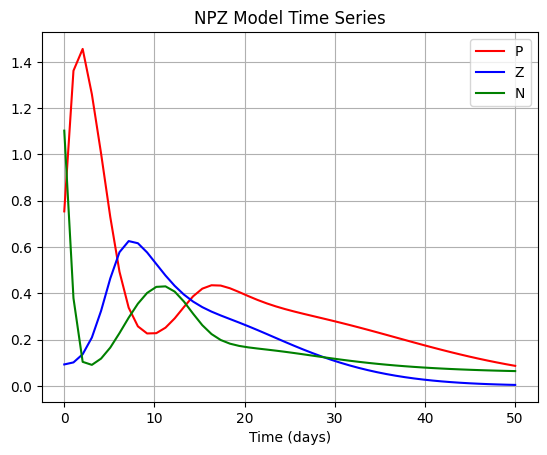

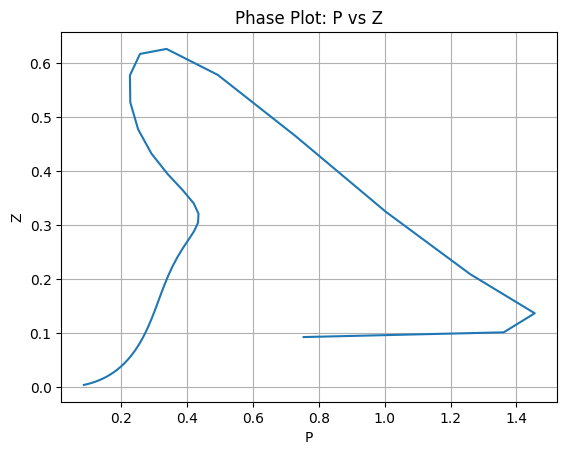

In [5]:
# Plotting
time = np.linspace(0, ndays, steps)

plt.figure()
plt.plot(time, SP, 'r', label='P')
plt.plot(time, SZ, 'b', label='Z')
plt.plot(time, SN, 'g', label='N')
plt.xlabel('Time (days)')
plt.legend()
plt.title('NPZ Model Time Series')
plt.grid()

plt.figure()
plt.plot(SP, SZ)
plt.xlabel('P')
plt.ylabel('Z')
plt.title('Phase Plot: P vs Z')
plt.grid()

plt.show()